In [1]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam

from keras import backend as K
img_dim_ordering = 'tf'
K.set_image_dim_ordering(img_dim_ordering)

import numpy as np

Using TensorFlow backend.


In [2]:
from util import *

In [3]:
data_dir = 'data'

In [4]:
X_train_imgs_filename = '%s/X_train_imgs.csv' % data_dir
X_val_imgs_filename = '%s/X_val_imgs.csv' % data_dir
X_test_imgs_filename = '%s/X_test_imgs.csv' % data_dir
y_train_filename = '%s/y_train.csv' % data_dir
y_val_filename = '%s/y_val.csv' % data_dir
y_test_filename = '%s/y_test.csv' % data_dir

In [5]:
X_train_img_files = read_img_file_csv(X_train_imgs_filename)
X_val_img_files = read_img_file_csv(X_val_imgs_filename)
X_test_img_files = read_img_file_csv(X_test_imgs_filename)
y_train = read_label_file_csv(y_train_filename)
y_val = read_label_file_csv(y_val_filename)
y_test = read_label_file_csv(y_test_filename)

In [6]:
def pretrained_model(img_shape, num_classes, activation='relu', n=4096, lr=0.001):
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)
    for layer in model_vgg16_conv.layers:
        layer.trainable = False
        
    #model_vgg16_conv.summary()
    
    #Create your own input format
    keras_input = Input(shape=img_shape, name = 'image_input')
    
    #Use the generated model 
    output_vgg16_conv = model_vgg16_conv(keras_input)
    
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(n, activation=activation, name='fc1')(x)
    x = Dense(n, activation=activation, name='fc2')(x)
    x = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    #Create your own model 
    pretrained_model = Model(inputs=keras_input, outputs=x)
    optimizer = Adam(lr=lr)
    pretrained_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return pretrained_model

In [7]:
X_train_imgs = read_imgs(X_train_img_files, scale_to_255=True)
X_train_imgs.shape

(12432, 64, 64, 3)

In [8]:
X_train_img_files[:5]

['data/non-vehicles/GTI/image1314.png',
 'data/non-vehicles/GTI/image1630.png',
 'data/non-vehicles/GTI/image1838.png',
 'data/non-vehicles/GTI/image3168.png',
 'data/vehicles/KITTI_extracted/3822.png']

In [9]:
def vgg_load_imgs(X_img_files):
    X_img_arr = []
    for img_path in tqdm(X_img_files):
        #print(img_path)
        curr_img = image.load_img(img_path, target_size=(64, 64))
        X_img_arr.append(curr_img.copy())
        curr_img.close()

    X_imgs = np.stack(X_img_arr)    
    
    return X_imgs.astype(np.float32)/255.0

In [10]:
X_train_img_files, y_train = shuffle_train_data(X_train_img_files, y_train)

cutoff = int(0.1*len(y_train))
_X_train_img_files = X_train_img_files[:cutoff]
_y_train = y_train[:cutoff]

_X_train = vgg_load_imgs(_X_train_img_files)
_X_train.shape

In [11]:
X_train = vgg_load_imgs(X_train_img_files)
X_train.shape

100%|██████████████████████████████████████████████████████████████████████████| 12432/12432 [00:02<00:00, 4244.45it/s]


(12432, 64, 64, 3)

In [12]:
X_train[0].min(), X_train[0].max()

(0.21176471, 0.99607843)

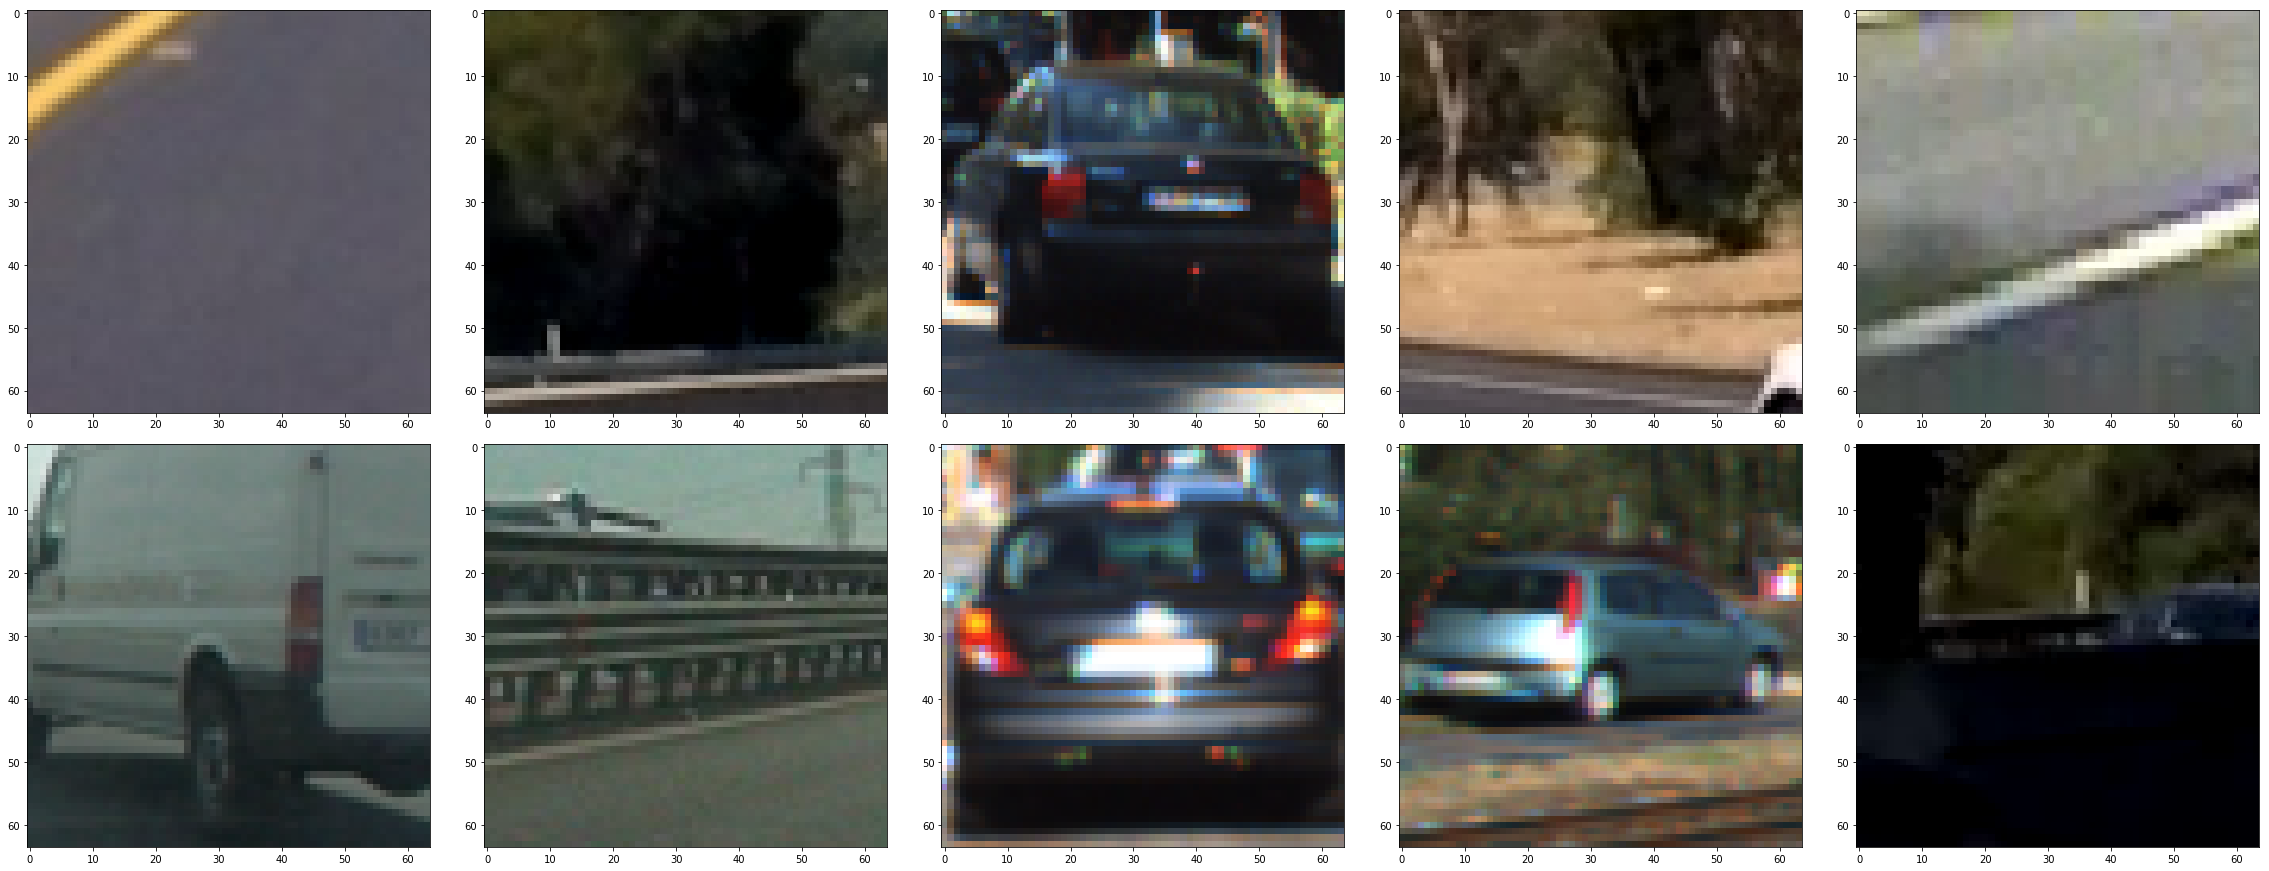

In [13]:
display_images(X_train, start_idx=0, end_idx=10)

In [14]:
X_val = vgg_load_imgs(X_val_img_files)
X_val.shape

100%|████████████████████████████████████████████████████████████████████████████| 3569/3569 [00:00<00:00, 4233.70it/s]


(3569, 64, 64, 3)

In [15]:
X_test = vgg_load_imgs(X_test_img_files)
X_test.shape

100%|████████████████████████████████████████████████████████████████████████████| 1759/1759 [00:00<00:00, 4259.09it/s]


(1759, 64, 64, 3)

In [16]:
model = pretrained_model((64, 64, 3), 2, n=512, lr=0.0001)

In [17]:
model.fit(x=X_train, y=np.array(y_train), batch_size=32, epochs=10, verbose=2, callbacks=None, 
          validation_data=(X_val, np.array(y_val)), shuffle=True, initial_epoch=0)

Train on 12432 samples, validate on 3569 samples
Epoch 1/10
 - 9s - loss: 0.0577 - acc: 0.9785 - val_loss: 0.0215 - val_acc: 0.9930
Epoch 2/10
 - 8s - loss: 0.0219 - acc: 0.9920 - val_loss: 0.0105 - val_acc: 0.9950
Epoch 3/10
 - 8s - loss: 0.0136 - acc: 0.9944 - val_loss: 0.0076 - val_acc: 0.9969
Epoch 4/10
 - 8s - loss: 0.0120 - acc: 0.9951 - val_loss: 0.0144 - val_acc: 0.9961
Epoch 5/10
 - 8s - loss: 0.0097 - acc: 0.9967 - val_loss: 0.0106 - val_acc: 0.9958
Epoch 6/10
 - 8s - loss: 0.0056 - acc: 0.9980 - val_loss: 0.0176 - val_acc: 0.9944
Epoch 7/10
 - 8s - loss: 0.0096 - acc: 0.9962 - val_loss: 0.0109 - val_acc: 0.9961
Epoch 8/10
 - 8s - loss: 0.0036 - acc: 0.9986 - val_loss: 0.0187 - val_acc: 0.9944
Epoch 9/10
 - 8s - loss: 0.0046 - acc: 0.9985 - val_loss: 0.0111 - val_acc: 0.9958
Epoch 10/10
 - 8s - loss: 0.0024 - acc: 0.9994 - val_loss: 0.0150 - val_acc: 0.9964


In [19]:
model.evaluate(X_test, np.array(y_test))

1759/1759 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 433us/step


[0.022869647409665784, 0.99715747583854464]